# Honeycomb Walk Problem: Complete Explanation

## Problem Overview

The honeycomb walk is a **random walk on the edges of a hexagonal lattice** where the walker's turning behavior is determined by the colors of hexagons. It's a discrete model that exhibits complex emergent behavior from simple local rules.

## Physical Setup

### The Lattice
- **Hexagonal grid** with M rows and N columns (N must be even)
- Walker moves along the **edges** of hexagons, not through their centers
- Each vertex is a **lattice point** where hexagon edges meet
- Edge length = 1 unit

### Coordinate System
- **Origin (0,0)**: Bottom-middle edge, between two central hexagons
- **Y-axis**: Vertical, pointing upward
- **X-axis**: Horizontal, with hexagonal lattice geometry
- **Lattice spacing**: Adjacent vertices separated by unit distances along hexagon edges

### Hexagon Coloring Rules
1. **Interior hexagons**: Randomly colored with probability p
   - Probability p → Gray hexagon
   - Probability (1-p) → White hexagon
2. **Boundary hexagons**: Fixed colors
   - **Left boundary**: All gray
   - **Right boundary**: All white  
   - **Bottom boundary**: Gray if x < 0, white if x ≥ 0
   - **Top boundary**: Gray if x < x_split, white if x ≥ x_split
   - Where x_split = ((M-1) % 2) × (√3/2)

## Walker Dynamics

### Movement Rules
1. **Start**: Position (0,0), facing upward
2. **Each step**:
   - Look at the hexagon directly ahead
   - If **gray hexagon** → turn **60° right**, then step forward
   - If **white hexagon** → turn **60° left**, then step forward
3. **Continue** until natural termination (reaching boundaries)

### Direction System
The walker can face 6 directions on the hexagonal lattice:
- 0: Up (0, 1)
- 1: Up-left (-√3/2, 1/2)  
- 2: Down-left (-√3/2, -1/2)
- 3: Down (0, -1)
- 4: Down-right (√3/2, -1/2)
- 5: Up-right (√3/2, 1/2)

### Key Insight: Boundary Funnel Effect
The boundary coloring creates a **natural funnel**:
- Walker starting at bottom-middle
- Left gray boundary pushes walker rightward  
- Right white boundary pushes walker leftward
- Top boundary has split point that acts as natural exit
- Walker should automatically reach top-middle exit point

## Mathematical Properties

### Hexagonal Lattice Geometry
- **Dual relationship**: Hexagonal lattice is dual to triangular lattice
- **Coordinate mapping**: Points (x,y) map to hexagon indices (r,c)
- **Index calculation** (from MATLAB):
  ```
  X = round(1 + (2/3)(y - sin(π/6)))
  r = X - 1
  if X even: Y = round(x/(2cos(π/6)) + N/2)
  if X odd:  Y = round(x/(2cos(π/6)) + (N+1)/2)  
  c = Y - 1
  ```

### Probabilistic Behavior
- **Interior randomness**: Each interior hexagon colored independently
- **Path uniqueness**: Given fixed random seed, path is deterministic
- **Boundary conditions**: Ensure finite, well-defined walks
- **Emergence**: Complex global paths from simple local rules

## Physical Interpretation

This model can represent:
1. **Particle diffusion** in structured medium with random scatterers
2. **Light ray propagation** through random optical medium  
3. **Brownian motion** with directional bias
4. **Percolation problems** on hexagonal lattices
5. **Game theory** models with spatial structure

## Computational Challenges

### Floating-Point Precision
- Hexagonal geometry involves √3, which has infinite decimal expansion
- Cumulative arithmetic errors can cause coordinate drift
- Solution: Aggressive coordinate cleaning at each step

### Lazy Coloring Consistency  
- Each hexagon must have **exactly one** color throughout simulation
- Cache key must uniquely identify each physical hexagon
- Use hexagon center coordinates (not grid indices) as cache keys

### Loop Prevention
- Incorrect coloring logic can create deterministic loops
- Proper boundary conditions should prevent infinite walks
- Natural termination occurs when walker reaches boundary exit

## Expected Behavior

For a correctly implemented system:
1. **Finite walks**: All walks terminate at boundaries
2. **Upward bias**: Bottom boundary pushes walker generally upward  
3. **Centering effect**: Side boundaries push walker toward middle
4. **Natural exit**: Walker emerges at top-middle boundary
5. **Path variability**: Different random seeds give different paths
6. **Statistical properties**: Path statistics depend on probability p

## Code Implementation Goals

1. **Accurate geometry**: Correct hexagonal lattice coordinates
2. **Consistent coloring**: Each hexagon gets exactly one color
3. **Clean arithmetic**: Eliminate floating-point drift
4. **Natural termination**: No artificial goal-checking needed
5. **Boundary correctness**: Proper boundary color assignments
6. **Debugging capability**: Track walker state and decisions

The beauty of this problem lies in how **simple local rules** (turn left/right based on color) combined with **carefully designed boundary conditions** produce **complex emergent paths** that naturally solve a geometric boundary value problem.

In [1]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Dict, Tuple, List, Optional
import matplotlib.pyplot as plt
import math
import random

Honeycomb Walk Demonstration
Grid size: 30 rows × 40 columns
Gray probability: 0.5

Walk terminated naturally after 749 steps
Walk Statistics:
  Total Steps: 749
  Unique Positions: 750
  Revisited Positions: 0
  Final Position: (0.8660254, 47.5)
  Hexagons Colored: 509
  Path Length: 750

Path sample (first 10 positions):
  Step 0: (0.0, 0.0)
  Step 1: (0.0, 1.0)
  Step 2: (0.8660254, 1.5)
  Step 3: (1.73205081, 1.0)
  Step 4: (2.59807621, 1.5)
  Step 5: (3.46410162, 1.0)
  Step 6: (4.33012702, 1.5)
  Step 7: (5.19615242, 1.0)
  Step 8: (5.19615242, 0.0)
  Step 9: (6.06217783, -0.5)
  ...
  Step 749: (0.8660254, 47.5)


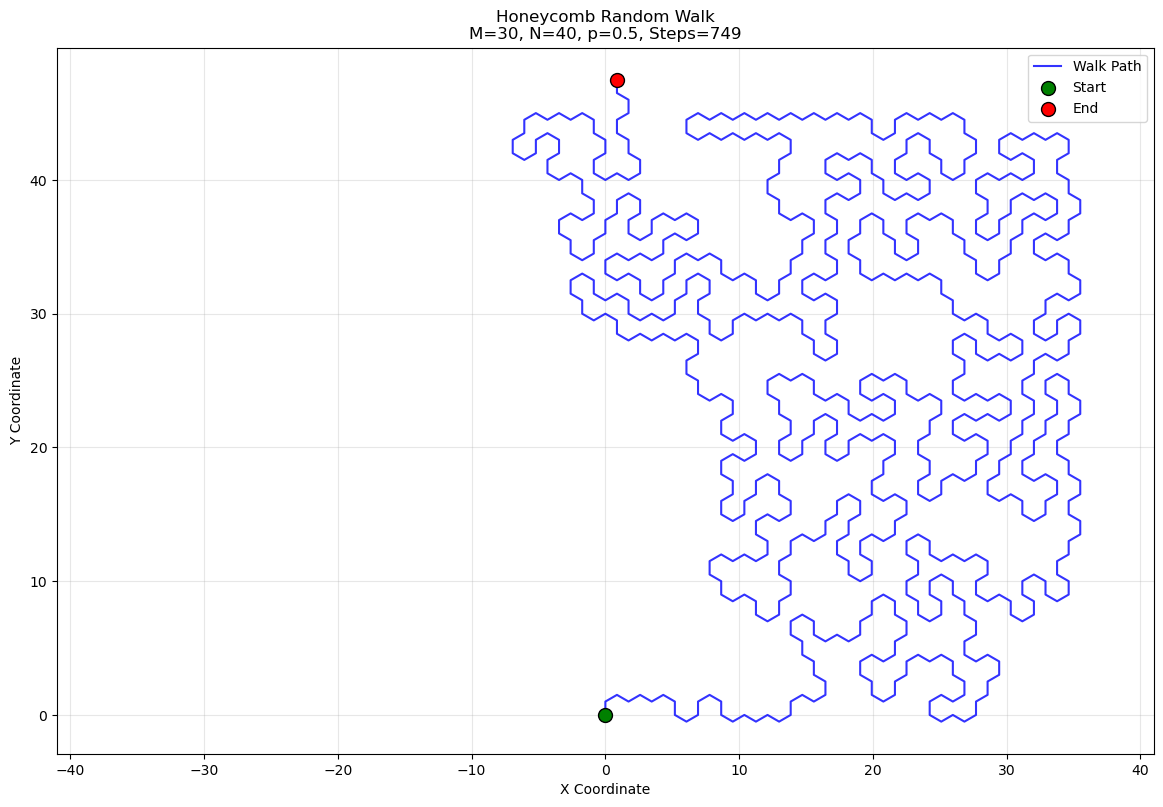

In [2]:
# Geometric constants for hexagonal lattice
SQRT3 = math.sqrt(3.0)
COS30 = SQRT3 / 2.0
SIN30 = 0.5

def clean_coordinate(coord: float, tolerance: float = 1e-12) -> float:
    """Clean floating-point coordinate to eliminate precision errors."""
    rounded = round(coord, 12)
    return 0.0 if abs(rounded) < tolerance else rounded

@dataclass
class HoneycombWalk:
    """
    A random walk on hexagonal lattice edges with color-based turning rules.
    
    The walker moves along hexagon edges, turning left (60°) at white hexagons
    and right (60°) at gray hexagons. Boundary conditions ensure natural 
    termination from bottom-middle to top-middle of the grid.
    """
    
    # Grid parameters
    M: int                          # Number of hexagon rows (vertical)
    N: int                          # Number of hexagon columns (horizontal, must be even)
    p: float                        # Probability of gray color for interior hexagons
    seed: Optional[int] = None      # Random seed for reproducibility
    
    # Output precision
    coordinate_precision: int = 8   # Decimal places for stored coordinates
    
    # Internal state
    path: List[Tuple[float, float]] = field(default_factory=list)
    _x: float = field(init=False, repr=False)           # Current exact x position  
    _y: float = field(init=False, repr=False)           # Current exact y position
    _direction: int = field(init=False, repr=False)     # Current facing direction (0-5)
    
    # Hexagon color cache: hex_center -> is_gray
    _colors: Dict[Tuple[float, float], bool] = field(default_factory=dict, repr=False)
    
    # Random number generator
    _rng: random.Random = field(default_factory=random.Random, repr=False)
    
    # Boundary configuration
    _boundary_config: Dict[str, float] = field(init=False, repr=False)
    
    def __post_init__(self):
        """Initialize the walker state and validate parameters."""
        # Validate parameters
        if self.N % 2 != 0:
            raise ValueError("N (number of columns) must be even")
        if not (0.0 <= self.p <= 1.0):
            raise ValueError("Probability p must be in [0, 1]")
            
        # Initialize random number generator
        if self.seed is not None:
            self._rng.seed(self.seed)
            
        # Define the 6 movement directions on hexagonal lattice
        self._directions = [
            (0.0, 1.0),              # 0: up
            (-SQRT3/2, 0.5),         # 1: up-left  
            (-SQRT3/2, -0.5),        # 2: down-left
            (0.0, -1.0),             # 3: down
            (SQRT3/2, -0.5),         # 4: down-right
            (SQRT3/2, 0.5),          # 5: up-right
        ]
        
        # Configure boundary colors
        x_top_split = ((self.M - 1) % 2) * (SQRT3 / 2)
        self._boundary_config = {
            'left_gray': True,           # Left boundary: all gray
            'right_gray': False,         # Right boundary: all white
            'bottom_split_x': 0.0,       # Bottom: gray if x < 0, white if x >= 0
            'top_split_x': x_top_split,  # Top: gray if x < x_top_split, white if x >= x_top_split
        }
        
        # Initialize walker at bottom-middle, facing up
        self._x = 0.0
        self._y = 0.0
        self._direction = 0  # facing up
        
        # Record starting position
        self._record_position()
        
        # Take first step upward
        self._move_forward()
        self._record_position()
    
    def _record_position(self):
        """Record current position in path with specified precision."""
        x_clean = clean_coordinate(self._x)
        y_clean = clean_coordinate(self._y)
        x_out = round(x_clean, self.coordinate_precision)
        y_out = round(y_clean, self.coordinate_precision)
        self.path.append((x_out, y_out))
    
    def _get_front_point(self) -> Tuple[float, float]:
        """Get the point one step ahead in current direction."""
        dx, dy = self._directions[self._direction]
        front_x = clean_coordinate(self._x + dx)
        front_y = clean_coordinate(self._y + dy)
        return front_x, front_y
    
    def _point_to_hex_indices(self, x: float, y: float) -> Tuple[int, int]:
        """
        Convert lattice point coordinates to hexagon grid indices.
        
        Uses the MATLAB indexing formula:
        X = round(1 + (2/3)*(y - sin(π/6)))
        Y = round(x/(2*cos(π/6)) + N/2) [if X even] or (N+1)/2 [if X odd]
        
        Returns zero-based (row, col) indices.
        """
        X = round(1.0 + (2.0/3.0) * (y - SIN30))
        row = X - 1
        
        if X % 2 == 0:
            Y = round(x / (2.0 * COS30) + self.N / 2.0)
        else:
            Y = round(x / (2.0 * COS30) + (self.N + 1.0) / 2.0)
        col = Y - 1
        
        return row, col
    
    def _hex_indices_to_center(self, row: int, col: int) -> Tuple[float, float]:
        """
        Convert hexagon grid indices back to hexagon center coordinates.
        This provides a unique, consistent key for each physical hexagon.
        """
        # Reverse the indexing calculation
        X = row + 1
        Y = col + 1
        
        if X % 2 == 0:  # Even X
            center_x = (Y - self.N / 2.0) * (2.0 * COS30)
        else:  # Odd X  
            center_x = (Y - (self.N + 1.0) / 2.0) * (2.0 * COS30)
        
        center_y = (X - 1) * 1.5 + SIN30
        
        # Clean coordinates for consistency
        center_x = clean_coordinate(center_x)
        center_y = clean_coordinate(center_y)
        
        return center_x, center_y
    
    def _is_boundary_hex(self, row: int, col: int) -> bool:
        """Check if hexagon at (row, col) is on the boundary."""
        return row < 0 or row >= self.M or col < 0 or col >= self.N
    
    def _get_boundary_color(self, x: float, row: int, col: int) -> bool:
        """
        Get the color of a boundary hexagon based on boundary conditions.
        Returns True for gray, False for white.
        """
        config = self._boundary_config
        
        if col < 0:  # Left boundary
            return config['left_gray']
        elif col >= self.N:  # Right boundary  
            return config['right_gray']
        elif row < 0:  # Bottom boundary
            return x < config['bottom_split_x']  # Gray if x < 0, white if x >= 0
        else:  # Top boundary (row >= M)
            return x < config['top_split_x']  # Gray if x < x_split, white if x >= x_split
    
    def _get_hex_color(self) -> bool:
        """
        Determine the color of the hexagon directly ahead.
        Returns True for gray (turn right), False for white (turn left).
        """
        # Get the point we're looking at
        front_x, front_y = self._get_front_point()
        
        # Convert to hexagon indices
        row, col = self._point_to_hex_indices(front_x, front_y)
        
        # Check if it's a boundary hexagon
        if self._is_boundary_hex(row, col):
            return self._get_boundary_color(front_x, row, col)
        
        # Interior hexagon: use lazy coloring with hex center as key
        hex_center = self._hex_indices_to_center(row, col)
        
        if hex_center not in self._colors:
            # First time seeing this hexagon - assign random color
            self._colors[hex_center] = (self._rng.random() < self.p)
        
        return self._colors[hex_center]
    
    def _turn_left(self):
        """Turn 60 degrees left (counterclockwise)."""
        self._direction = (self._direction + 1) % 6
    
    def _turn_right(self):
        """Turn 60 degrees right (clockwise)."""
        self._direction = (self._direction - 1) % 6
    
    def _move_forward(self):
        """Move one step forward in current direction."""
        dx, dy = self._directions[self._direction]
        self._x = clean_coordinate(self._x + dx)
        self._y = clean_coordinate(self._y + dy)
    
    def _is_at_boundary(self) -> bool:
        """
        Check if walker has reached a boundary position where it should stop.
        This happens naturally due to boundary conditions.
        """
        x, y = self._x, self._y
        
        # Check if we're outside the expected lattice bounds
        # This is a safety check - proper boundary conditions should guide walker to exit
        max_x = self.N * SQRT3
        max_y = self.M * 1.5 + 2
        
        return (abs(x) > max_x or y > max_y or y < -1)
    
    def step(self) -> bool:
        """
        Execute one step of the random walk.
        Returns True if step was taken, False if walk should terminate.
        """
        # Check if we should stop (safety boundary check)
        if self._is_at_boundary():
            return False
        
        # Look at hexagon ahead and determine its color
        is_gray = self._get_hex_color()
        
        # Turn based on hexagon color
        if is_gray:
            self._turn_right()
        else:
            self._turn_left()
        
        # Move forward
        self._move_forward()
        
        # Record new position
        self._record_position()
        
        return True
    
    def run(self, max_steps: int = 100000) -> List[Tuple[float, float]]:
        """
        Run the complete random walk until natural termination.
        
        The walk should terminate naturally when the walker reaches the 
        boundary exit point due to the funnel effect of boundary conditions.
        
        Args:
            max_steps: Safety limit to prevent infinite loops
            
        Returns:
            List of (x, y) coordinates representing the complete path
        """
        step_count = 0
        
        while step_count < max_steps:
            if not self.step():
                print(f"Walk terminated naturally after {step_count + 1} steps")
                break
            step_count += 1
        else:
            print(f"Walk stopped after reaching maximum steps ({max_steps})")
        
        return self.path
    
    @property
    def current_position(self) -> Tuple[float, float]:
        """Get current walker position (cleaned coordinates)."""
        return clean_coordinate(self._x), clean_coordinate(self._y)
    
    @property
    def current_direction(self) -> int:
        """Get current walker direction (0-5)."""
        return self._direction
    
    @property
    def colors_used(self) -> int:
        """Get number of interior hexagons that have been colored."""
        return len(self._colors)
    
    def get_statistics(self) -> Dict[str, any]:
        """Get statistics about the completed walk."""
        if len(self.path) < 2:
            return {"error": "Walk too short for statistics"}
        
        # Calculate path length
        total_distance = len(self.path) - 1  # Number of steps
        
        # Find unique positions (detect any revisits)
        unique_positions = len(set(self.path))
        revisits = len(self.path) - unique_positions
        
        # Get final position
        final_pos = self.path[-1]
        
        return {
            "total_steps": total_distance,
            "unique_positions": unique_positions,
            "revisited_positions": revisits,
            "final_position": final_pos,
            "hexagons_colored": self.colors_used,
            "path_length": len(self.path)
        }


def demonstrate_honeycomb_walk():
    """Demonstrate the honeycomb walk with visualization."""
    # Parameters
    M, N = 30, 40  # rows, columns
    prob = 0.5    # probability of gray hexagons
    SEED = 7
    print("Honeycomb Walk Demonstration")
    print("=" * 40)
    print(f"Grid size: {M} rows × {N} columns")
    print(f"Gray probability: {prob}")
    print()
    
    # Create and run walk
    walker = HoneycombWalk(M=M, N=N, p=prob, seed=SEED)  # Fixed seed for reproducibility
    path = walker.run()
    
    # Print statistics
    stats = walker.get_statistics()
    print("Walk Statistics:")
    for key, value in stats.items():
        print(f"  {key.replace('_', ' ').title()}: {value}")
    
    # Show path sample
    print(f"\nPath sample (first 10 positions):")
    for i, pos in enumerate(path[:10]):
        print(f"  Step {i}: {pos}")
    
    if len(path) > 10:
        print(f"  ...")
        print(f"  Step {len(path)-1}: {path[-1]}")
    
    # Create visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    if len(path) > 1:
        # Extract coordinates
        x_coords, y_coords = zip(*path)
        
        # Plot path
        ax.plot(x_coords, y_coords, 'b-', linewidth=1.5, alpha=0.8, label='Walk Path')
        
        # Mark start and end
        ax.scatter(x_coords[0], y_coords[0], color='green', s=100, 
                  label='Start', zorder=5, edgecolors='black')
        ax.scatter(x_coords[-1], y_coords[-1], color='red', s=100, 
                  label='End', zorder=5, edgecolors='black')
        
        # Add grid and formatting
        ax.grid(True, alpha=0.3)
        ax.set_xlim(-N-1, N+1)
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.set_title('Honeycomb Random Walk\n'
                    f'M={M}, N={N}, p={prob}, Steps={len(path)-1}')
        ax.legend()
        ax.set_aspect('equal')
        
        plt.tight_layout()
        plt.show()
    
    return walker


# Run demonstration when script is executed directly
if __name__ == "__main__":
    walker = demonstrate_honeycomb_walk()